# Original notebook:
https://www.kaggle.com/code/takanashihumbert/cibmtr-using-official-metric-in-tree-based-models/notebook

In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from colorama import Fore, Back, Style

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, LabelEncoder
import os, glob, math, gc, warnings, random, joblib
from sklearn.metrics import roc_auc_score

from catboost import CatBoostClassifier, Pool, CatBoostRegressor
from xgboost import XGBRegressor, XGBClassifier
import xgboost as xgb
print("we are using xgboost ==", xgb.__version__)
from lightgbm import LGBMRegressor, callback

from lifelines.utils import concordance_index
from lifelines import KaplanMeierFitter

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

we are using xgboost == 2.1.4


In [2]:
class ParticipantVisibleError(Exception):
    pass


def custom_score(solution, submission, row_id_column_name, prediction_label='prediction', print_info=True):
    
    del solution[row_id_column_name]
    del submission[row_id_column_name]
    
    event_label = 'efs'
    interval_label = 'efs_time'
    
    for col in submission.columns:
        if not pd.api.types.is_numeric_dtype(submission[col]):
            raise ParticipantVisibleError(f'Submission column {col} must be a number')
    # Merging solution and submission dfs on ID
    merged_df = pd.concat([solution, submission], axis=1)
    merged_df.reset_index(inplace=True)
    merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)
    metric_dict = {}
    for race in sorted(merged_df_race_dict.keys()):
        # Retrieving values from y_test based on index
        indices = sorted(merged_df_race_dict[race])
        merged_df_race = merged_df.iloc[indices]
        # Calculate the concordance index
        c_index_race = concordance_index(
                        merged_df_race[interval_label],
                        -merged_df_race[prediction_label],
                        merged_df_race[event_label])

        metric_dict[race] = c_index_race

    race_c_index = list(metric_dict.values())
    c_score = float(np.mean(race_c_index) - np.std(race_c_index))
    if print_info:
        print(f"{Fore.GREEN}{Style.BRIGHT}# c-index={c_score:.4f}, mean={np.mean(race_c_index):.4f} std={np.std(race_c_index):.4f}{Style.RESET_ALL}")
    
    return c_score, metric_dict


def display_overall(df):
    
    race_groups = [
        'American Indian or Alaska Native', 'Asian',
       'Black or African-American', 'More than one race',
       'Native Hawaiian or other Pacific Islander', 'White'
    ]
    df['mean'] = df[race_groups].mean(axis=1)
    df['std'] = np.std(df[race_groups], axis=1)
    df['score'] = df['mean'] - df['std']
    df = df.T
    df['Overall'] = df.mean(axis=1)
    temp = df.drop(index=['std']).values
    display(df
            .iloc[:len(race_groups)]
            .style
            .format(precision=4)
            .background_gradient(axis=None, vmin=temp.min(), vmax=temp.max(), cmap="cool")
            .concat(df.iloc[len(race_groups):].style.format(precision=3))
           )


# Load Train and Test

In [3]:
test = pd.read_csv("data/test.csv")
print("Test shape:", test.shape )

train = pd.read_csv("data/train.csv")
print("Train shape:",train.shape)

Test shape: (3, 58)
Train shape: (28800, 60)


In [4]:
def transform_survival_probability(df, time_col='efs_time', event_col='efs'):
    """
    Transform using survival probability estimates
    """
    kmf = KaplanMeierFitter()
    kmf.fit(df[time_col], df[event_col])
    y = kmf.survival_function_at_times(df[time_col]).values
    
    return y

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


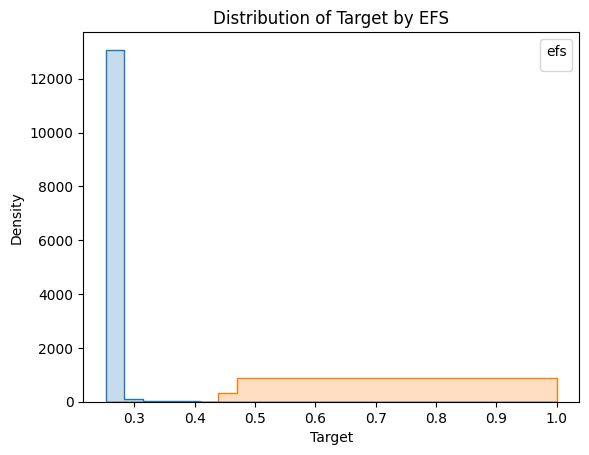

In [5]:
train["label"] = transform_survival_probability(train, time_col='efs_time', event_col='efs')
train.loc[train['efs']==0, 'label'] -= 0.2

sns.histplot(data=train, x='label', hue='efs', element='step', common_norm=False)
plt.legend(title='efs')
plt.title('Distribution of Target by EFS')
plt.xlabel('Target')
plt.ylabel('Density')
plt.show()

In [6]:
RMV = ["ID","efs","efs_time","label",'y','kfold']
FEATURES = [c for c in train.columns if not c in RMV]
print(f"There are {len(FEATURES)} FEATURES: {FEATURES}")

There are 57 FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10']


In [7]:
CAT_FEATURES = []
for c in FEATURES:
    if train[c].dtype=="object":
        CAT_FEATURES.append(c)
        train[c] = train[c].fillna("NAN")
        test[c] = test[c].fillna("NAN")

In [8]:
combined = pd.concat([train, test], axis=0, ignore_index=True)
print("The CATEGORICAL FEATURES: ",end="")
for c in FEATURES:
    if c in CAT_FEATURES:
        print(f"{c}, ", end="")
        combined[c] = combined[c].astype("category")
    else:
        if combined[c].dtype=="float64":
            combined[c] = combined[c].astype("float32")
        if combined[c].dtype=="int64":
            combined[c] = combined[c].astype("int32")

train = combined.iloc[:len(train)].copy()
test = combined.iloc[len(train):].reset_index(drop=True).copy()

The CATEGORICAL FEATURES: dri_score, psych_disturb, cyto_score, diabetes, tbi_status, arrhythmia, graft_type, vent_hist, renal_issue, pulm_severe, prim_disease_hct, cmv_status, tce_imm_match, rituximab, prod_type, cyto_score_detail, conditioning_intensity, ethnicity, obesity, mrd_hct, in_vivo_tcd, tce_match, hepatic_severe, prior_tumor, peptic_ulcer, gvhd_proph, rheum_issue, sex_match, race_group, hepatic_mild, tce_div_match, donor_related, melphalan_dose, cardiac, pulm_moderate, 

In [9]:
train.head()

,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,hla_high_res_6,cmv_status,hla_high_res_10,hla_match_dqb1_high,tce_imm_match,hla_nmdp_6,hla_match_c_low,rituximab,hla_match_drb1_low,hla_match_dqb1_low,prod_type,cyto_score_detail,conditioning_intensity,ethnicity,year_hct,obesity,mrd_hct,in_vivo_tcd,tce_match,hla_match_a_high,hepatic_severe,donor_age,prior_tumor,hla_match_b_low,peptic_ulcer,age_at_hct,hla_match_a_low,gvhd_proph,rheum_issue,sex_match,hla_match_b_high,race_group,comorbidity_score,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time,label
0,0,N/A - non-malignant indication,No,NAN,No,NaN,NaN,No TBI,No,6.0,Bone marrow,No,No,No,IEA,6.0,+/+,NaN,2.0,NAN,6.0,2.0,No,2.0,2.0,BM,NAN,NAN,Not Hispanic or Latino,2016,No,NAN,Yes,NAN,2.0,No,NaN,No,2.0,No,9.942000,2.0,FKalone,No,M-F,2.0,More than one race,0.0,90.0,No,NAN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,42.356,0.258687
1,1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,Peripheral blood,No,No,No,AML,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,PB,Intermediate,MAC,Not Hispanic or Latino,2008,No,Positive,No,Permissive,2.0,No,72.290001,No,2.0,No,43.705002,2.0,Other GVHD Prophylaxis,No,F-F,2.0,Asian,3.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1.0,4.672,0.847759
2,2,N/A - non-malignant indication,No,NAN,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,HIS,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,NAN,NAN,Not Hispanic or Latino,2019,No,NAN,Yes,NAN,2.0,No,NaN,No,2.0,No,33.997002,2.0,Cyclophosphamide alone,No,F-M,2.0,More than one race,0.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,19.793,0.262424
3,3,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,ALL,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,Intermediate,MAC,Not Hispanic or Latino,2009,No,Positive,No,Permissive,2.0,No,29.230000,No,2.0,No,43.244999,2.0,FK+ MMF +- others,No,M-M,2.0,White,0.0,90.0,Yes,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,102.349,0.256661
4,4,High,No,NAN,No,2.0,8.0,No TBI,No,6.0,Peripheral blood,No,No,No,MPN,6.0,+/+,10.0,2.0,NAN,5.0,2.0,No,2.0,2.0,PB,NAN,MAC,Hispanic or Latino,2018,No,NAN,Yes,NAN,2.0,No,56.810001,No,2.0,No,29.740000,2.0,TDEPLETION +- other,No,M-F,2.0,American Indian or Alaska Native,1.0,90.0,No,Permissive mismatched,Related,MEL,8.0,No,2.0,No,10.0,0.0,16.223,0.264674


In [10]:
folds = 5
train['kfold'] = -1  

skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
groups = train['efs'].astype(str)
for fold, (train_idx, val_idx) in enumerate(skf.split(X=train, y=groups)):
    train.loc[val_idx, 'kfold'] = fold

# Custom Metrics

In [11]:
def CIndexMetric_XGB(y_true, y_pred):
    ds_pred["prediction"] = y_pred
    cindex_score, _ = custom_score(ds_true.copy(), ds_pred.copy(), "ID", print_info=False)
    return -cindex_score

def CIndexMetric_LGB(y_true, y_pred):
    ds_pred["prediction"] = y_pred
    cindex_score, _ = custom_score(ds_true.copy(), ds_pred.copy(), "ID", print_info=False)
    return ('C-Index', cindex_score, True)

# XGBoost

In [12]:
%%time

oof_xgb = train[['kfold','ID','efs','efs_time','label','race_group']].copy()
oof_xgb['prediction'] = 0.0
feature_importances_xgb = pd.DataFrame()
feature_importances_xgb['feature'] = FEATURES
metric_df = []

for fold in range(skf.n_splits):
    
    x_train = train[train.kfold != fold].copy()
    x_valid = train[train.kfold == fold].copy()

    y_train = x_train['label']
    y_valid = x_valid['label']
    y_label = x_valid['efs']

    x_train = x_train[FEATURES]
    x_valid = x_valid[FEATURES]

    # define two extra dataframe for the custom metric
    ds_true = oof_xgb.loc[oof_xgb.kfold==fold, ["ID","efs","efs_time","race_group"]].copy().reset_index(drop=True)
    ds_pred = oof_xgb.loc[oof_xgb.kfold==fold, ["ID"]].copy().reset_index(drop=True)
    
    clf = XGBRegressor(
        tree_method="gpu_hist",
        max_depth=3,
        colsample_bytree=0.5, 
        subsample=0.8, 
        n_estimators=10000,  
        learning_rate=0.03,
        early_stopping_rounds=100,
        objective='reg:squarederror',
        enable_categorical=True,
        min_child_weight=5,
        eval_metric=CIndexMetric_XGB, # the custom metric
        disable_default_eval_metric=True # only show the custom metric
    )
    clf.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],
        verbose=500,
    )
    feature_importances_xgb[f'fold_{fold + 1}'] = feature_importances_xgb['feature'].map(clf.get_booster().get_score())

    preds_valid = clf.predict(x_valid)
    oof_xgb.loc[oof_xgb.kfold==fold, 'prediction'] = preds_valid

    # don't use joblib or pickle to save the model(Cannot load it)
    clf.save_model(f"xgb_model_{fold}.bin")

    y_true = oof_xgb.loc[oof_xgb.kfold==fold, ["ID","efs","efs_time","race_group"]].copy().reset_index(drop=True)
    y_pred = oof_xgb.loc[oof_xgb.kfold==fold, ["ID","prediction"]].copy().reset_index(drop=True)
    m, metric_dict = custom_score(y_true, y_pred, "ID", print_info=True)
    metric_df.append(metric_dict)

XGBoostError: [22:13:10] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:861: Exception in gpu_hist: [22:13:10] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device


In [ ]:
# For inference:
# model_path = f"./xxx/xgb_model.bin"
# model = XGBRegressor()
# model.load_model(model_path)
# prediction = model.predict()

In [ ]:
y_true = oof_xgb[["ID","efs","efs_time","race_group"]].copy().reset_index(drop=True)
y_pred = oof_xgb[["ID","prediction"]].copy().reset_index(drop=True)
m, _ = custom_score(y_true, y_pred, "ID", print_info=True)
print(f"Overall official SCORE: {m:.5f}")

metric_df_ = pd.DataFrame(metric_df)
display_overall(metric_df_)

In [ ]:
feature_importances_xgb['importance'] = feature_importances_xgb.drop('feature', axis=1).mean(axis=1)
feature_importances_xgb = feature_importances_xgb.sort_values('importance', ascending=False).reset_index(drop=True)
feature_importances_xgb.head(20)

# Lightgbm

In [ ]:
%%time
    
oof_lgb = train[['kfold','ID','efs','efs_time','label','race_group']].copy()
oof_lgb['prediction'] = 0.0
feature_importances_lgb = pd.DataFrame()
feature_importances_lgb['feature'] = FEATURES
metric_df = []

for fold in range(skf.n_splits):
    
    x_train = train[train.kfold != fold].copy()
    x_valid = train[train.kfold == fold].copy()

    y_train = x_train['label']
    y_valid = x_valid['label']
    y_label = x_valid['efs']

    x_train = x_train[FEATURES]
    x_valid = x_valid[FEATURES]

    ds_true = oof_lgb.loc[oof_lgb.kfold==fold, ["ID","efs","efs_time","race_group"]].copy().reset_index(drop=True)
    ds_pred = oof_lgb.loc[oof_lgb.kfold==fold, ["ID"]].copy().reset_index(drop=True)

    lgb_params = {
        'max_depth': 6,
        'num_leaves': 40,
        'learning_rate': 0.03,
        'n_estimators': 10000,
        'objective': 'l2',
        'subsample': 0.8,
        'colsample_bytree': 0.5,
        'n_jobs': -1,
        'verbose': -1,
        'device': 'gpu',
        'metric': 'None' # only show the custom metric
    }
    clf = LGBMRegressor(**lgb_params)
    clf.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],
        categorical_feature=CAT_FEATURES,
        eval_metric=CIndexMetric_LGB, # the custom metric
        callbacks=[callback.log_evaluation(500), callback.early_stopping(100)]
    )
    feature_importances_lgb[f'fold_{fold + 1}'] = clf.feature_importances_

    preds_valid = clf.predict(x_valid)
    oof_lgb.loc[oof_lgb.kfold==fold, 'prediction'] = preds_valid

    joblib.dump(clf, f"lgb_model_{fold}.pkl")

    y_true = oof_lgb.loc[oof_lgb.kfold==fold, ["ID","efs","efs_time","race_group"]].copy().reset_index(drop=True)
    y_pred = oof_lgb.loc[oof_lgb.kfold==fold, ["ID","prediction"]].copy().reset_index(drop=True)
    m, metric_dict = custom_score(y_true, y_pred, "ID", print_info=True)
    metric_df.append(metric_dict)

In [ ]:
# For inference:
# model_path = f"./xxx/lgb_model.pkl"
# model = joblib.load(model_path)
# prediction = model.predict()

In [ ]:
y_true = oof_lgb[["ID","efs","efs_time","race_group"]].copy().reset_index(drop=True)
y_pred = oof_lgb[["ID","prediction"]].copy().reset_index(drop=True)
m, _ = custom_score(y_true, y_pred, "ID", print_info=True)
print(f"Overall official SCORE: {m:.5f}")

metric_df_ = pd.DataFrame(metric_df)
display_overall(metric_df_)

In [ ]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = 0.5*oof_xgb['prediction'].rank(pct=True) + 0.5*oof_lgb['prediction'].rank(pct=True)

m, _ = custom_score(y_true, y_pred, "ID", print_info=True)
print(f"Overall official SCORE: {m:.5f}")